In [1]:
APIKEY = 'e3n925jex7m9v3hfs466cx8e'

In [17]:
import requests
import pandas as pd
import time
import numpy as np

In [3]:
pd.set_option('max_columns', None)

In [4]:
szn = 'https://api.sportradar.us/nba/trial/v7/en/seasons/2018/REG/rankings.json?api_key={}'.format(APIKEY)
szn_data = requests.get(szn).json()

In [5]:
def team_ID(team):
    name_id = {}

    divs = [x['divisions'] for x in szn_data['conferences']]
    teams1 = [x['teams'] for x in divs[0]]
    teams2 = [x['teams'] for x in divs[1]]
    for x in teams1:
        for y in x:
            name_id[y['name']] = y['id']
    for x in teams2:
        for y in x:
            name_id[y['name']] = y['id']
    
    teamid = name_id[team]
    return teamid
    

def get_stats(team):
    
    teamID = team_ID(team)
    item = requests.get('https://api.sportradar.us/nba/trial/v7/en/seasons/2018/REG/teams/{}/statistics.json?api_key={}'.format(teamID, APIKEY))
    data = item.json()
    return data

def get_team_frame():
    teams = []

    divs = [x['divisions'] for x in szn_data['conferences']]
    teams1 = [x['teams'] for x in divs[0]]
    teams2 = [x['teams'] for x in divs[1]]
    for x in teams1:
        for y in x:
            teams.append(y['name'])
    for x in teams2:
        for y in x:
            teams.append(y['name'])
            
    players = {}
    team_frames = []
    for x in teams:
        time.sleep(1)
        ts, p = own_vs_opp(x)
        team_frames.append(ts)
        players[x] = p
    return pd.concat(team_frames), players

def own_vs_opp(team):
    teamd = get_stats(team)
    own_rec = pd.DataFrame(teamd['own_record']).T
    own_rec.columns = ['own_' + str(col) for col in own_rec.columns]
    own_rec.index = [str(team)+ '_' + str(col) for col in own_rec.index]
    opp_rec = pd.DataFrame(teamd['opponents']).T
    opp_rec.columns = ['opp_' + str(col) for col in opp_rec.columns]
    opp_rec.index = [str(team)+ '_' + str(col) for col in opp_rec.index]
    team_stats = pd.concat([opp_rec, own_rec], axis=1)
    
    playas = pd.DataFrame.from_dict([x for x in teamd['players']])
    temp1 = playas['total'].apply(pd.Series)
    playas[temp1.columns] = temp1
    playas.drop('total', axis=1, inplace=True)
    temp2 = playas['average'].apply(pd.Series)
    playas[temp2.columns] = temp2
    playas.drop('average', axis=1, inplace=True)
    
    return team_stats, playas

def get_schedule(year):
    access_level = 'trial'
    version = 'v7'
    language_code = 'en'
    season_year = str(year)
    nba_season = 'REG'
    format='json'
    url = 'https://api.sportradar.us/nba/{}/{}/{}/games/{}/{}/schedule.{}?api_key={}'.format(access_level, version, language_code, season_year, nba_season, format, APIKEY)
    item = requests.get(url)
    data = item.json()
    return data

def get_season(year):

    sched = get_schedule(year)   


    games = [x for x in sched['games']]
    new_dict = {}
    i=0
    frames = []

    for a in range(0, (len(games))):
        for x in games[a]:
            if isinstance(games[a][x], dict):
                i = str(x)
                for y in games[a][x]:
                    new_dict[i+ '_' + str(y)] = games[a][x][y]

            elif isinstance(games[a][x], list):
                i= str(x)
                for z in games[a][x][0]:
                    new_dict[i+ '_' + str(z)] = games[a][x][0][z]
            else:
                new_dict[str(x)] = games[a][x]

        data = pd.DataFrame(new_dict, index=[0])
        frames.append(data)
        new_dict={}

    season = pd.concat(frames)
        
    return season

def get_standings(year):
    access_level = 'trial'
    version = 'v7'
    language_code = 'en'
    season_year = str(year)
    nba_season = 'REG'
    format='json'
    url = 'https://api.sportradar.us/nba/{}/{}/{}/seasons/{}/{}/standings.{}?api_key={}'.format(access_level, version, language_code, season_year, nba_season, format, APIKEY)
    item = requests.get(url)
    data = item.json()
    return data



def get_season_results(year):
    stands = get_standings(year)
    divs = [x['divisions'] for x in stands['conferences']]
    teams = []
    new_dict = {}
    for x in divs:
        for y in x:
            teams.append([z for z in y['teams']])
    frames = []
    teamys = []

    for x in range(len(teams)):

        for y in range(len(teams[x])):
            dictw = {}
            name = str(teams[x][y]['name'])
            teamys.append(name)

            for z in teams[x][y]:

                if isinstance(teams[x][y][z], dict):

                    for i in teams[x][y][z]:
                        dictw[str(i)] = teams[x][y][z][i]

                elif isinstance(teams[x][y][z], list):

                    for diction in teams[x][y][z]:
                        stringer = str(diction['record_type'])

                        for thing in diction:
                            dictw[stringer + '_' +  str(thing)] = diction[thing]

                else:
                    dictw[str(z)] = teams[x][y][z]


            data = pd.DataFrame(dictw, index=[0])
            frames.append(data)
    
    season_results = pd.concat(frames)
    return season_results


In [251]:
tfu, p = get_team_frame()

In [7]:
pd.DataFrame(p['Knicks']).head()

,id,full_name,first_name,last_name,position,primary_position,jersey_number,sr_id,reference,name_suffix,games_played,games_started,minutes,field_goals_made,field_goals_att,field_goals_pct,two_points_made,two_points_att,two_points_pct,three_points_made,three_points_att,three_points_pct,blocked_att,free_throws_made,free_throws_att,free_throws_pct,offensive_rebounds,defensive_rebounds,rebounds,assists,turnovers,assists_turnover_ratio,steals,blocks,personal_fouls,tech_fouls,points,flagrant_fouls,ejections,foulouts,true_shooting_att,true_shooting_pct,efficiency,points_off_turnovers,points_in_paint,points_in_paint_made,points_in_paint_att,points_in_paint_pct,effective_fg_pct,double_doubles,triple_doubles,fouls_drawn,offensive_fouls,fast_break_pts,fast_break_att,fast_break_made,fast_break_pct,coach_ejections,second_chance_pct,second_chance_pts,second_chance_att,second_chance_made,minus,plus,coach_tech_fouls,off_rebounds,def_rebounds
0,0036a1fa-ff9a-44a5-8061-68b828ee2b1e,DeAndre Jordan,DeAndre,Jordan,C,C,6,sr:player:607508,201599,NaN,19.0,19.0,25.9,4.11,6.47,0.634,4.11,6.47,0.634,0.00,0.00,0.000,0.47,2.68,3.47,0.773,64.0,152.0,11.37,3.0,2.21,1.36,0.47,1.05,2.21,1.0,10.9,0.0,0.0,1.0,8.00,0.681,21.42,1.05,8.11,4.05,6.26,0.647,0.634,12.0,0.0,3.16,0.26,0.42,0.26,0.16,0.600,0.0,0.667,3.68,2.21,1.47,1215.0,1017.0,0.0,3.37,8.00
1,08e85fa8-427d-4464-8d5c-666d7b65632b,Billy Garrett,Billy,Garrett,G,SG,NaN,sr:player:1726674,1628656,NaN,4.0,0.0,15.8,2.75,6.75,0.407,2.75,4.75,0.579,0.00,2.00,0.000,0.00,1.00,1.00,1.000,0.0,3.0,0.75,1.8,0.50,3.50,0.25,0.25,0.75,0.0,6.5,0.0,0.0,0.0,7.19,0.452,5.00,0.00,4.00,2.00,3.00,0.667,0.407,0.0,0.0,1.00,0.00,0.00,0.25,0.00,0.000,0.0,0.000,0.00,0.00,0.00,149.0,133.0,0.0,0.00,0.75
2,2226ff79-37ff-4b63-baeb-13df74890454,Damyean Dotson,Damyean,Dotson,G,SG,21,sr:player:1143620,1628422,NaN,73.0,40.0,27.5,3.97,9.56,0.415,2.25,4.88,0.461,1.73,4.68,0.368,0.22,1.00,1.34,0.745,34.0,228.0,3.59,1.8,0.97,1.90,0.79,0.14,1.85,0.0,10.7,0.0,0.0,0.0,10.15,0.526,10.14,1.51,2.27,1.14,2.41,0.472,0.506,1.0,0.0,1.18,0.08,1.37,1.03,0.51,0.493,0.0,0.544,1.08,0.78,0.42,4670.0,4343.0,0.0,0.47,3.12
3,239f0ff0-3d09-4991-bb67-ad8c8b7fd0cb,Kevin Knox,Kevin,Knox,F,SF,20,sr:player:1307730,1628995,NaN,75.0,57.0,28.8,4.51,12.19,0.370,2.84,7.33,0.387,1.67,4.85,0.343,0.80,2.16,3.01,0.717,61.0,274.0,4.47,1.1,1.52,0.72,0.57,0.32,2.33,0.0,12.8,0.0,0.0,0.0,13.51,0.475,9.24,1.87,4.59,2.29,5.05,0.454,0.438,3.0,0.0,2.32,0.16,1.88,1.29,0.68,0.526,0.0,0.329,1.13,1.13,0.37,5278.0,4641.0,0.0,0.81,3.65
4,35cd1338-c56b-4247-b53c-264585c59883,Tim Hardaway Jr.,Tim,Hardaway,F-G,SF,11,sr:player:608188,203501,Jr.,46.0,46.0,32.6,6.13,15.78,0.388,3.59,8.46,0.424,2.54,7.33,0.347,1.00,4.33,5.07,0.854,26.0,135.0,3.50,2.7,1.76,1.51,0.91,0.13,2.30,0.0,19.1,0.0,0.0,1.0,18.01,0.531,14.17,2.54,4.39,2.20,4.98,0.441,0.469,2.0,0.0,4.15,0.09,2.46,1.93,0.89,0.461,0.0,0.375,1.52,1.39,0.52,3649.0,3320.0,0.0,0.57,2.93


In [25]:
tf.head()

,opp_games_played,opp_minutes,opp_field_goals_made,opp_field_goals_att,opp_field_goals_pct,opp_two_points_made,opp_two_points_att,opp_two_points_pct,opp_three_points_made,opp_three_points_att,opp_three_points_pct,opp_blocked_att,opp_free_throws_made,opp_free_throws_att,opp_free_throws_pct,opp_offensive_rebounds,opp_defensive_rebounds,opp_rebounds,opp_assists,opp_turnovers,opp_assists_turnover_ratio,opp_steals,opp_blocks,opp_personal_fouls,opp_tech_fouls,opp_points,opp_fast_break_pts,opp_flagrant_fouls,opp_points_off_turnovers,opp_second_chance_pts,opp_ejections,opp_foulouts,opp_points_in_paint,opp_efficiency,opp_true_shooting_att,opp_true_shooting_pct,opp_points_in_paint_made,opp_points_in_paint_att,opp_points_in_paint_pct,opp_effective_fg_pct,opp_bench_points,opp_fouls_drawn,opp_offensive_fouls,opp_team_tech_fouls,opp_defensive_assists,opp_fast_break_att,opp_fast_break_made,opp_fast_break_pct,opp_technical_other,opp_coach_ejections,opp_points_against,opp_team_defensive_rebounds,opp_team_offensive_rebounds,opp_second_chance_att,opp_second_chance_made,opp_second_chance_pct,opp_coach_tech_fouls,opp_team_fouls,opp_total_rebounds,opp_total_fouls,opp_off_rebounds,opp_def_rebounds,own_games_played,own_minutes,own_field_goals_made,own_field_goals_att,own_field_goals_pct,own_two_points_made,own_two_points_att,own_two_points_pct,own_three_points_made,own_three_points_att,own_three_points_pct,own_blocked_att,own_free_throws_made,own_free_throws_att,own_free_throws_pct,own_offensive_rebounds,own_defensive_rebounds,own_rebounds,own_assists,own_turnovers,own_assists_turnover_ratio,own_steals,own_blocks,own_personal_fouls,own_tech_fouls,own_points,own_fast_break_pts,own_flagrant_fouls,own_points_off_turnovers,own_second_chance_pts,own_ejections,own_foulouts,own_points_in_paint,own_efficiency,own_true_shooting_att,own_true_shooting_pct,own_points_in_paint_made,own_points_in_paint_att,own_points_in_paint_pct,own_effective_fg_pct,own_bench_points,own_fouls_drawn,own_offensive_fouls,own_team_tech_fouls,own_defensive_assists,own_fast_break_att,own_fast_break_made,own_fast_break_pct,own_technical_other,own_coach_ejections,own_points_against,own_team_defensive_rebounds,own_team_offensive_rebounds,own_second_chance_att,own_second_chance_made,own_second_chance_pct,own_coach_tech_fouls,own_team_fouls,own_total_rebounds,own_total_fouls,own_off_rebounds,own_def_rebounds
Raptors_total,82.0,19880.0,3302.00,7352.00,0.449,2420.00,4793.00,0.505,882.00,2559.00,0.345,437.00,1399.00,1829.00,0.765,867.0,2804.0,3671.00,2012.0,1225.00,1.64,622.00,368.00,1683.00,50.0,8885.0,1107.00,3.00,1299.00,1057.00,4.0,6.0,3896.00,9853.00,8156.76,0.545,1948.00,3627.00,0.537,0.509,3160.00,1724.00,146.00,13.0,0.0,760.00,431.00,0.567,0.0,1.0,9384.0,155.0,522.0,881.00,400.00,0.454,2.0,16.0,4348.0,1699.0,NaN,NaN,82.0,19880.0,3460.00,7305.00,0.474,2445.00,4534.00,0.539,1015.00,2771.00,0.366,368.00,1449.00,1803.00,0.804,786.0,2920.0,3706.00,2085.0,1150.00,1.81,680.00,437.00,1724.00,73.0,9384.0,1506.00,3.00,1414.00,1037.00,1.0,10.0,3980.00,10943.00,8098.32,0.579,1990.00,3487.00,0.571,0.543,2972.00,1683.00,145.00,35.0,0.0,972.00,563.00,0.579,0.0,1.0,8885.0,171.0,454.0,792.00,404.00,0.510,8.0,44.0,4331.0,1768.0,NaN,NaN
Raptors_average,NaN,242.4,40.27,89.66,NaN,29.51,58.45,NaN,10.76,31.21,NaN,5.33,17.06,22.30,NaN,NaN,NaN,44.77,24.5,14.94,NaN,7.59,4.49,20.52,NaN,108.4,13.50,0.04,15.84,12.89,NaN,NaN,47.51,120.16,99.47,NaN,23.76,44.23,NaN,NaN,38.54,21.02,1.78,NaN,NaN,9.27,5.26,NaN,NaN,NaN,NaN,NaN,NaN,10.74,4.88,NaN,NaN,NaN,NaN,NaN,10.57,34.20,NaN,242.4,42.20,89.09,NaN,29.82,55.29,NaN,12.38,33.79,NaN,4.49,17.67,21.99,NaN,NaN,NaN,45.20,25.4,14.02,NaN,8.29,5.33,21.02,NaN,114.4,18.37,0.04,17.24,12.65,NaN,NaN,48.54,133.45,98.76,NaN,24.27,42.52,NaN,NaN,36.24,20.52,1.77,NaN,NaN,11.85,6.87,NaN,NaN,NaN,NaN,NaN,NaN,9.66,4.93,NaN,NaN,NaN,NaN,NaN,9.59,35.61
76ers_total,82.0,19805.0,3418.00,7506.00,0.455,2575.00,5042.00,0.511,843.00,2464.00,0.342,432.00,1545.00,2011.00,0.768,823.0,2743.0,3566.00,1917.0,

In [9]:
sr = get_season_results(2018)
sr.head()

,id,name,market,wins,losses,win_pct,points_for,points_against,point_diff,sr_id,reference,league,conference,division,kind,length,div_rank,conf_rank,atlantic_record_type,atlantic_wins,atlantic_losses,atlantic_win_pct,below_500_record_type,below_500_wins,below_500_losses,below_500_win_pct,central_record_type,central_wins,central_losses,central_win_pct,conference_record_type,conference_wins,conference_losses,conference_win_pct,division_record_type,division_wins,division_losses,division_win_pct,equal_rebounds_record_type,equal_rebounds_wins,equal_rebounds_losses,equal_rebounds_win_pct,equal_turnovers_record_type,equal_turnovers_wins,equal_turnovers_losses,equal_turnovers_win_pct,fewer_turnovers_record_type,fewer_turnovers_wins,fewer_turnovers_losses,fewer_turnovers_win_pct,home_record_type,home_wins,home_losses,home_win_pct,last_10_record_type,last_10_wins,last_10_losses,last_10_win_pct,last_10_home_record_type,last_10_home_wins,last_10_home_losses,last_10_home_win_pct,last_10_road_record_type,last_10_road_wins,last_10_road_losses,last_10_road_win_pct,leads_field_goal_pct_record_type,leads_field_goal_pct_wins,leads_field_goal_pct_losses,leads_field_goal_pct_win_pct,leads_rebounds_record_type,leads_rebounds_wins,leads_rebounds_losses,leads_rebounds_win_pct,northwest_record_type,northwest_wins,northwest_losses,northwest_win_pct,opponent_fewer_turnovers_record_type,opponent_fewer_turnovers_wins,opponent_fewer_turnovers_losses,opponent_fewer_turnovers_win_pct,opponent_leads_field_goal_pct_record_type,opponent_leads_field_goal_pct_wins,opponent_leads_field_goal_pct_losses,opponent_leads_field_goal_pct_win_pct,opponent_leads_rebounds_record_type,opponent_leads_rebounds_wins,opponent_leads_rebounds_losses,opponent_leads_rebounds_win_pct,opponent_scores_100_or_more_record_type,opponent_scores_100_or_more_wins,opponent_scores_100_or_more_losses,opponent_scores_100_or_more_win_pct,overtime_record_type,overtime_wins,overtime_losses,overtime_win_pct,over_500_record_type,over_500_wins,over_500_losses,over_500_win_pct,pacific_record_type,pacific_wins,pacific_losses,pacific_win_pct,road_record_type,road_wins,road_losses,road_win_pct,scores_100_or_more_record_type,scores_100_or_more_wins,scores_100_or_more_losses,scores_100_or_more_win_pct,southeast_record_type,southeast_wins,southeast_losses,southeast_win_pct,southwest_record_type,southwest_wins,southwest_losses,southwest_win_pct,ten_points_record_type,ten_points_wins,ten_points_losses,ten_points_win_pct,three_points_record_type,three_points_wins,three_points_losses,three_points_win_pct,conf_tiebreak,div_tiebreak
0,583ec825-fb46-11e1-82cb-f4ce4684ea4c,Warriors,Golden State,57,25,0.695,117.68,111.22,6.46,sr:team:3428,1610612744,3.0,0.0,0.0,loss,1,1,1,atlantic,6,4,0.6,below_500,22,9,0.710,central,8,2,0.8,conference,35,17,0.673,division,13,3,0.813,equal_rebounds,2,0,1.00,equal_turnovers,3,5,0.375,fewer_turnovers,27,5,0.844,home,30,11,0.732,last_10,8,2,0.8,last_10_home,7,3,0.7,last_10_road,7,3,0.7,leads_field_goal_pct,51,9,0.850,leads_rebounds,33,7,0.825,northwest,12,6,0.667,opponent_fewer_turnovers,27,15,0.643,opponent_leads_field_goal_pct,5,14,0.263,opponent_leads_rebounds,22,18,0.550,opponent_scores_100_or_more,47,25,0.653,overtime,0,5,0.000,over_500,35,16,0.686,pacific,13,3,0.813,road,27,14,0.659,scores_100_or_more,57,17,0.770,southeast,8,2,0.8,southwest,10,8,0.556,ten_points,34,10,0.773,three_points,7,7,0.500,NaN,NaN
0,583ecdfb-fb46-11e1-82cb-f4ce4684ea4c,Clippers,LA,48,34,0.585,115.15,114.29,0.85,sr:team:3425,1610612746,12.0,9.0,9.0,win,1,2,8,atlantic,6,4,0.6,below_500,26,9,0.743,central,7,3,0.7,conference,28,24,0.538,division,11,5,0.688,equal_rebounds,1,1,0.50,equal_turnovers,3,2,0.600,fewer_turnovers,19,11,0.633,home,26,15,0.634,last_10,6,4,0.6,last_10_home,7,3,0.7,last_10_road,6,4,0.6,leads_field_goal_pct,37,8,0.822,leads_rebounds,31,8,0.795,northwest,7,11,0.389,opponent_fewer_turnovers,26,21,0.553,opponent_leads_field_goal_pct,11,25,0.306,opponent_leads_rebounds,16,25,0.390,opponent_scores_

In [8]:
season_2018 = get_season(2018)
season_2018.head()

,id,status,coverage,scheduled,home_points,away_points,track_on_court,sr_id,reference,time_zones_venue,time_zones_home,time_zones_away,venue_id,venue_name,venue_capacity,venue_address,venue_city,venue_state,venue_zip,venue_country,venue_sr_id,broadcasts_network,broadcasts_type,broadcasts_locale,broadcasts_channel,home_name,home_alias,home_id,home_sr_id,home_reference,away_name,away_alias,away_id,away_sr_id,away_reference,conference_game,title,neutral_site
0,4c06f6af-980b-41b3-85c3-5975d8e03956,closed,full,2018-10-17T00:00:00Z,105,87,True,sr:match:15328942,0021800001,US/Eastern,US/Eastern,US/Eastern,7d69b080-91ca-53c9-9302-45c1a72c5549,TD Garden,18624,100 Legends Way,Boston,MA,02114,USA,sr:venue:5940,TNT,TV,National,245,Boston Celtics,BOS,583eccfa-fb46-11e1-82cb-f4ce4684ea4c,sr:team:3422,1610612738,Philadelphia 76ers,PHI,583ec87d-fb46-11e1-82cb-f4ce4684ea4c,sr:team:3420,1610612755,NaN,NaN,NaN
0,3594f3a2-86b8-4337-83d3-269c078c7f1f,closed,full,2018-10-17T02:30:00Z,108,100,True,sr:match:15329656,0021800002,US/Pacific,US/Pacific,US/Central,e25e21f2-1d67-5f13-910b-81fc8629eea7,Oakland Arena,19596,7000 Coliseum Way,Oakland,CA,94621,USA,sr:venue:6922,TNT,TV,National,245,Golden State Warriors,GSW,583ec825-fb46-11e1-82cb-f4ce4684ea4c,sr:team:3428,1610612744,Oklahoma City Thunder,OKC,583ecfff-fb46-11e1-82cb-f4ce4684ea4c,sr:team:3418,1610612760,NaN,NaN,NaN
0,24b19539-d496-460a-9e9b-2194d0fcc82a,closed,full,2018-10-17T23:00:00Z,103,100,True,sr:match:15329324,0021800004,US/Eastern,US/Eastern,US/Eastern,5a9ddefc-2267-4fd1-8d6e-0f82163ce8bd,Little Caesars Arena,20491,2645 Woodward Avenue,Detroit,MI,48201,USA,sr:venue:21782,FS-DET,TV,Home,663,Detroit Pistons,DET,583ec928-fb46-11e1-82cb-f4ce4684ea4c,sr:team:3424,1610612765,Brooklyn Nets,BKN,583ec9d6-fb46-11e1-82cb-f4ce4684ea4c,sr:team:3436,1610612751,NaN,NaN,NaN
0,35a15ba5-77f8-45f5-91a6-79bbc3fbf989,closed,full,2018-10-17T23:00:00Z,112,113,True,sr:match:15329130,0021800003,US/Eastern,US/Eastern,US/Central,a380f011-6e5d-5430-9f37-209e1e8a9b6f,Spectrum Center,19077,330 E. Trade Street,Charlotte,NC,28202,USA,sr:venue:6146,FS-WI,TV,Away,669,Charlotte Hornets,CHA,583ec97e-fb46-11e1-82cb-f4ce4684ea4c,sr:team:3430,1610612766,Milwaukee Bucks,MIL,583ecefd-fb46-11e1-82cb-f4ce4684ea4c,sr:team:3410,1610612749,NaN,NaN,NaN
0,b83e3709-b996-4df3-b448-af91c5566187,closed,full,2018-10-17T23:00:00Z,111,83,True,sr:match:15331020,0021800005,US/Eastern,US/Eastern,US/Eastern,24bb478e-eb31-5f8a-8c8d-07f513169ec1,Bankers Life Fieldhouse,20000,125 S. Pennsylvania Street,Indianapolis,IN,46204,USA,sr:venue:6924,FS-IN,TV,Home,671-4,Indiana Pacers,IND,583ec7cd-fb46-11e1-82cb-f4ce4684ea4c,sr:team:3419,1610612754,Memphis Grizzlies,MEM,583eca88-fb46-11e1-82cb-f4ce4684ea4c,sr:team:3415,1610612763,NaN,NaN,NaN


In [14]:
knicks_games = pd.concat([season_2018[(season_2018['home_name'] == 'New York Knicks')], season_2018[(season_2018['away_name'] == 'New York Knicks')]])

In [22]:
knicks_points

104.57317073170732

In [270]:
home = []
away = []
winner = []
for null, x in season_2018.iterrows():
    
    home.append(x['home_name'].split()[-1])
    away.append(x['away_name'].split()[-1])
    if x['home_points'] > x['away_points']:
        winner.append('home')
    else:
        winner.append('away')
res = (zip(home,away))

res = pd.DataFrame(res)
win = pd.DataFrame(np.array(winner))
home_away_results = pd.concat([res,win], axis=1)
home_away_results.columns = ['Home', 'Away', 'Winner']

home_away_results = home_away_results[home_away_results['Home'] != 'USA']
home_away_results = home_away_results[home_away_results['Home'] != 'World']
home_away_results = home_away_results[home_away_results['Home'] != 'East']
home_away_results = home_away_results[home_away_results['Home'] != 'West']
home_away_results = home_away_results[home_away_results['Away'] != 'USA']
home_away_results = home_away_results[home_away_results['Away'] != 'World']
home_away_results = home_away_results[home_away_results['Away'] != 'East']
home_away_results = home_away_results[home_away_results['Away'] != 'West']

In [271]:
# Start with df of average stats team frame
# Can't use post season stats due to lookahead bias
all_team_data = tfu[['average' in s for s in tfu.index]]
all_team_data = all_team_data.dropna(axis=1)
all_team_data = all_team_data.set_index(np.array([x.replace('_average', '') for x in list(all_team_data.index)]))
as_list = all_team_data.index.tolist()
idx = as_list.index('Trail Blazers')
as_list[idx] = 'Blazers'
all_team_data.index = as_list

In [272]:
combos = []
for x,y in home_away_results.iterrows():
    combos.append((y[0], y[1]))
len(combos)

1230

In [273]:
long_thing = all_team_data.loc[['Celtics', 'Kings']]
useful_cols = list(long_thing.columns)
home_cols = np.array(['home_' + str(x) for x in useful_cols])
away_cols = np.array(['away_' + str(x) for x in useful_cols])

frames = []
i=0
for x in combos:
    home = x[0]
    away = x[1]
    
    homedata = np.array(all_team_data.loc[home])
    homedataframe = pd.DataFrame(homedata).transpose()
    homedataframe.columns = home_cols

    awaydata = np.array(all_team_data.loc[away])
    awaydataframe = pd.DataFrame(awaydata).transpose()
    awaydataframe.columns = away_cols

    game_frame = pd.concat([homedataframe,awaydataframe], axis=1)
    frames.append(game_frame)


In [274]:
X = pd.concat(frames, axis=0)

In [275]:
Y = (home_away_results['Winner'])
Y = Y.map({'home':0, 'away':1})
Y

0       0
1       0
2       0
3       1
4       0
       ..
1227    1
1228    0
1229    0
1230    0
1231    0
Name: Winner, Length: 1230, dtype: int64

In [276]:
import datetime
import pandas as pd
import numpy as np
import yahoo_fin.stock_info as si

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, InputLayer

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, AUC

import matplotlib.pyplot as plt
import numpy

In [347]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.2, random_state=11)

In [348]:
ct = ColumnTransformer([('scale', StandardScaler(), list(X.columns))], remainder='passthrough')
x_train = ct.fit_transform(x_train)
x_test = ct.transform(x_test)

In [349]:
le = LabelEncoder()
y_train = le.fit_transform(y_train.astype(str))
y_test = le.transform(y_test.astype(str))

y_train = tf.keras.utils.to_categorical(y_train, dtype='int64')
y_test = tf.keras.utils.to_categorical(y_test, dtype='int64')

In [379]:
model = Sequential()

model.add(InputLayer(input_shape=x_train.shape[1]))
model.add(Dense(8, activation='relu'))
#model.add(Dropout(.2))
model.add(Dense(8, activation='relu'))
#model.add(Dense(8, activation='relu'))
#model.add(Dropout(.3))


model.add(Dense(2))

In [380]:
print(model.summary())

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_88 (Dense)             (None, 8)                 1128      
_________________________________________________________________
dense_89 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_90 (Dense)             (None, 2)                 18        
Total params: 1,218
Trainable params: 1,218
Non-trainable params: 0
_________________________________________________________________
None


In [381]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=.01), metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=20, batch_size=7, validation_data=(x_test, y_test), verbose=1)

Epoch 1/20
141/141 [==============================] - 0s 1ms/step - loss: 3.1562 - accuracy: 0.5460 - val_loss: 0.5998 - val_accuracy: 0.6951
Epoch 2/20
141/141 [==============================] - 0s 878us/step - loss: 0.6155 - accuracy: 0.6494 - val_loss: 0.6128 - val_accuracy: 0.6707
Epoch 3/20
141/141 [==============================] - 0s 852us/step - loss: 0.5752 - accuracy: 0.7196 - val_loss: 0.6303 - val_accuracy: 0.6707
Epoch 4/20
141/141 [==============================] - 0s 850us/step - loss: 0.5932 - accuracy: 0.6991 - val_loss: 0.6350 - val_accuracy: 0.6545
Epoch 5/20
141/141 [==============================] - 0s 850us/step - loss: 0.6190 - accuracy: 0.6521 - val_loss: 0.6146 - val_accuracy: 0.6911
Epoch 6/20
141/141 [==============================] - 0s 861us/step - loss: 0.5748 - accuracy: 0.7056 - val_loss: 0.6042 - val_accuracy: 0.6748
Epoch 7/20
141/141 [==============================] - 0s 867us/step - loss: 0.5827 - accuracy: 0.6961 - val_loss: 0.6263 - val_accuracy: 0

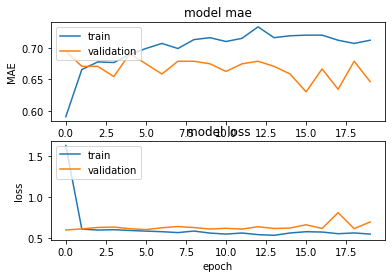

In [382]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model mae')
ax1.set_ylabel('MAE')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')
 
  # Plot loss and val_loss over each epoch
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')